# CNN

In [1]:
import numpy as np
import os, sys
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing import image
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping,LearningRateScheduler, ModelCheckpoint
import math

Using TensorFlow backend.


In [10]:
X_list = []
for filename in sorted(os.listdir('./Dataset_Resize/')):
    img = image.load_img(Path('./Dataset_Resize/', filename), target_size=(64, 64))
    X_list.append(image.img_to_array(img))
X = np.array(X_list)
X.shape

(9850, 64, 64, 3)

In [11]:
df = pd.read_csv('./vehicles.csv', index_col=0)
df_dummy = pd.get_dummies(df['Vehicle_Type'])
Y = np.array(df_dummy)
Y.shape

(9850, 6)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(8865, 64, 64, 3) (8865, 6)
(985, 64, 64, 3) (985, 6)


In [13]:
def AlexNet(input_shape):
    model = Sequential()
    # model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', padding='same', input_shape=input_shape))
    # for original Alexnet
    model.add(Conv2D(96, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    # Local Response normalization for Original Alexnet
    model.add(BatchNormalization())

    model.add(Conv2D(256, (5,5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(384, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(384, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(4096, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))

    # determine Loss function and Optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model;

In [14]:
model_Alex = AlexNet((64,64,3))
model_Alex.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 96)        2688      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 96)        384       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 256)       614656    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 384)         885120    
__________

In [15]:
early_Stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=1, 
    mode='auto'
)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
checkpointer = ModelCheckpoint(filepath="AlexNet.hdf5", verbose=1, save_best_only = True)
csv = CSVLogger('AlexNet.csv')

In [16]:
history = model_Alex.fit(X_train, Y_train,
                       batch_size=256,
                       epochs=100,
                       verbose=1,
                       validation_data=(X_test, Y_test),
                       shuffle=True,
                       callbacks=[early_Stopping,reduceLR,checkpointer,csv])

Train on 8865 samples, validate on 985 samples
Epoch 1/100
8865/8865 [==============================] - 209s 24ms/step - loss: 5.7496 - acc: 0.5724 - val_loss: 4.4643 - val_acc: 0.3472

Epoch 00001: val_loss improved from inf to 4.46425, saving model to AlexNet.hdf5
Epoch 2/100
8865/8865 [==============================] - 204s 23ms/step - loss: 2.2599 - acc: 0.6076 - val_loss: 1.0721 - val_acc: 0.6284

Epoch 00002: val_loss improved from 4.46425 to 1.07212, saving model to AlexNet.hdf5
Epoch 3/100
8865/8865 [==============================] - 206s 23ms/step - loss: 1.0425 - acc: 0.7011 - val_loss: 1.0436 - val_acc: 0.7218

Epoch 00003: val_loss improved from 1.07212 to 1.04357, saving model to AlexNet.hdf5
Epoch 4/100
8865/8865 [==============================] - 205s 23ms/step - loss: 0.7551 - acc: 0.7769 - val_loss: 1.0968 - val_acc: 0.7360

Epoch 00004: val_loss did not improve
Epoch 5/100
8865/8865 [==============================] - 206s 23ms/step - loss: 0.6339 - acc: 0.8131 - val_l

In [17]:
# Test the model
score = model_Alex.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.47822116822155597
Test accuracy: 0.9096446704743477


In [18]:
df = pd.read_csv('AlexNet.csv', index_col='epoch')
df.head()

,acc,loss,lr,val_acc,val_loss
epoch,,,,,
0,0.572363,5.749606,0.001,0.347208,4.464252
1,0.607558,2.259928,0.001,0.628426,1.072122
2,0.701072,1.042534,0.001,0.721827,1.043573
3,0.776875,0.755101,0.001,0.736041,1.096805
4,0.813085,0.633900,0.001,0.764467,0.976825


In [19]:
import seaborn as sns
from IPython.display import display
%matplotlib inline

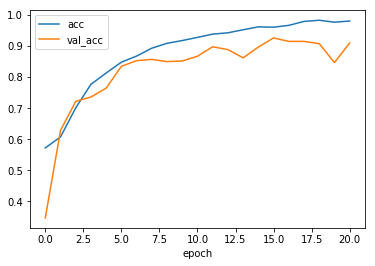

In [20]:
display(df[['acc', 'val_acc']].plot())